In [1]:
import pandas as pd
from faker import Faker
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import networkx as nx
fake = Faker(locale="zh_CN")

# 我们构建三个关系，4个节点的异构图
uid = ['uid_'+str(fake.random_int(10000, 10012)) for i in range(0,12)]
ip = ['ip_'+fake.ipv4() for i in range(0,4)]*3
uid1  = ['uid_'+str(fake.random_int(10000, 10100)) for i in range(0,100)]
email = ['em_'+fake.email() for i in range(0,50)]*2
phone = ['ph_'+fake.phone_number() for i in range(0,100)]*1

df1 = pd.DataFrame({
    'sr':uid,
    'ds':ip
})
df2 = pd.DataFrame({
    'sr':uid1,
    'ds':email
     })
df3 = pd.DataFrame({
    'sr':email,
    'ds':phone
     })
# 四个节点、三种关系合并
df = pd.concat([df1,df2,df3])

/opt/homebrew/anaconda3/envs/fintech/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


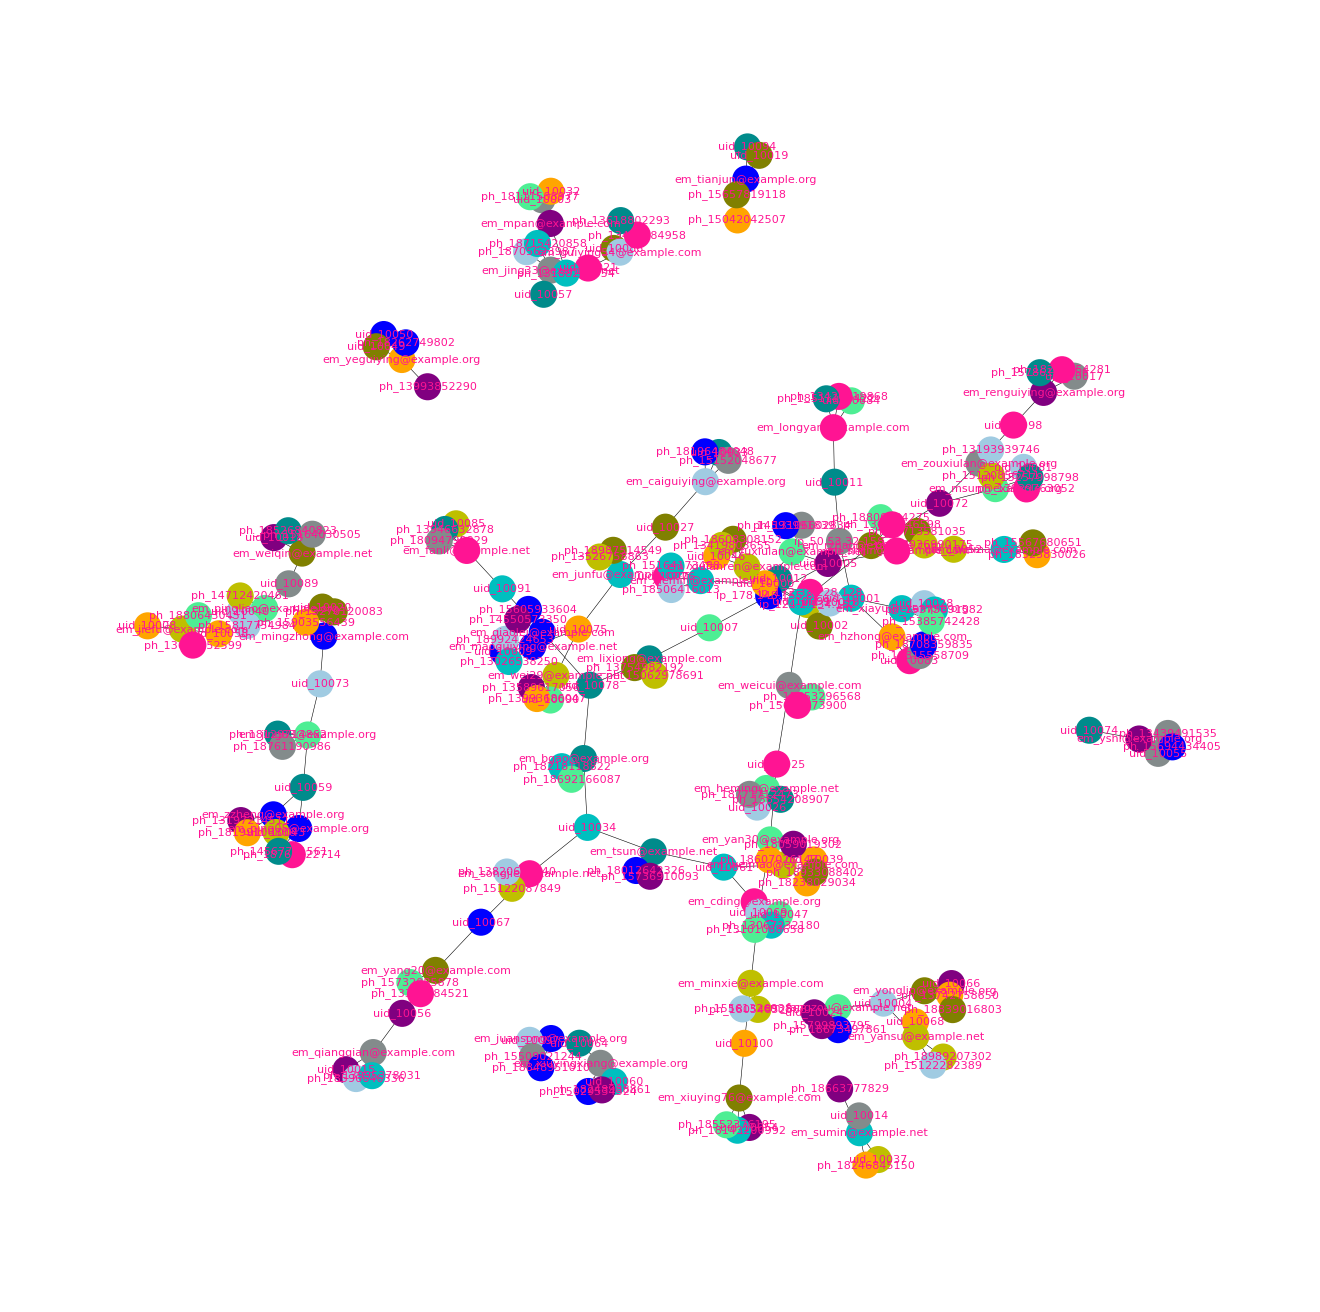

In [2]:
#图数据转换
da = df.values
G  = nx.Graph()
for num in range(len(da)):
    G.add_edge(str(da[num,0]),str(da[num,1]))
#显示图片
colors = ['#008B8B','b','orange','y','c','DeepPink','#838B8B','purple','olive','#A0CBE2','#4EEE94']*50
colors = colors[0:len(G.nodes())]

#显示该graph - spring_layout
plt.figure(figsize=(4,4),dpi=400)
nx.draw_networkx(G,
                 pos = nx.spring_layout(G),
                 node_color = colors,
                 font_color = 'DeepPink',
                 node_size=15,
                 font_size=2,
                 alpha=1.0,
                 width=0.1
                 )
plt.axis('off')
#plt.title("spring_layout")
plt.show()

In [3]:
# 找到所有连通子图
com = list(nx.connected_components(G))

# 打印看看什么格式的，可以看到得到的结果为列表-字典格式
print(com)

# 将 列表-字典 整理成数据表格形式
df_com  = pd.DataFrame()
for i in range(0, len(com)):
    d = pd.DataFrame({'group_id': [i] * len(com[i]), 'object_id': list(com[i])})
    df_com = pd.concat([df_com,d])

# 查看数据结果
df_com

# 统计每个团伙人数 并降序
df_com.groupby('group_id').count().sort_values(by='object_id', ascending=False)         
df_com[df_com['group_id']==4]

[{'uid_10067', 'uid_10015', 'em_bgao@example.org', 'ph_18511109422', 'em_longyan@example.com', 'uid_10012', 'ph_13420519868', 'ph_13339484521', 'ph_15605933604', 'em_xiayu@example.org', 'ph_13754982192', 'uid_10034', 'ph_15062978691', 'uid_10091', 'ph_18012642326', 'uid_10056', 'uid_10007', 'uid_10011', 'em_yang20@example.com', 'ip_50.53.32.158', 'uid_10039', 'ph_15385742428', 'ph_14550573350', 'em_shijing@example.com', 'ph_13995378031', 'em_xiemin@example.net', 'ph_18218118822', 'ip_172.33.228.128', 'uid_10010', 'ph_15567680651', 'ph_18596646336', 'em_hzhong@example.com', 'uid_10047', 'ph_13106602834', 'uid_10000', 'uid_10052', 'ph_15164173488', 'ph_13946632878', 'ph_18525830026', 'ph_18094799929', 'uid_10083', 'em_tsun@example.net', 'ph_15736910093', 'em_qiaolei@example.com', 'uid_10001', 'em_cding@example.org', 'em_songjie@example.net', 'ph_18506416013', 'uid_10002', 'em_fuxiulan@example.net', 'uid_10005', 'uid_10076', 'em_lixiong@example.com', 'ph_18238029034', 'ph_15375891582', 'i

,group_id,object_id
0,4,ph_18987514549
1,4,uid_10090
2,4,ph_13526758863
3,4,em_maoguiying@example.net
4,4,ph_15152048677
5,4,ph_13993686047
6,4,ph_13026538250
7,4,uid_10009
8,4,ph_18992424653
9,4,em_caiguiying@example.org


In [4]:
node2vec = Node2Vec(G, 
                    dimensions=64, 
                    walk_length=30, 
                    num_walks=200, 
                    workers=4
                    ) # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(
                     window=10, 
                     min_count=1, 
                     batch_words=4
                     )

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:01<00:00, 34.56it/s]


In [5]:
# 统计每个团伙人数 并降序 我们看看每个团伙d数量和明细
df_com.groupby('group_id').count().sort_values(by='object_id', ascending=False) 
df_com[df_com['group_id']==4]
# Look for most similar nodes
model.wv.most_similar('uid_10033',
                      topn = 20
                      ) 

[('ph_18196484048', 0.9988060593605042),
 ('ph_15152048677', 0.9963021278381348),
 ('em_caiguiying@example.org', 0.9771841764450073),
 ('uid_10027', 0.9438267946243286),
 ('em_junfu@example.com', 0.8550969958305359),
 ('ph_18987514549', 0.845003068447113),
 ('ph_13526758863', 0.8433530330657959),
 ('uid_10075', 0.7904597520828247),
 ('em_maoguiying@example.net', 0.7113828659057617),
 ('ph_18992424653', 0.699474573135376),
 ('em_wei29@example.net', 0.6994020342826843),
 ('ph_13589617056', 0.6990799307823181),
 ('ph_13026538250', 0.6956167817115784),
 ('uid_10090', 0.6827220916748047),
 ('uid_10009', 0.6817141175270081),
 ('ph_13993686047', 0.6786929368972778),
 ('ph_13603652599', 0.41901522874832153),
 ('ph_18806430451', 0.4170273542404175),
 ('uid_10058', 0.41674667596817017),
 ('uid_10008', 0.41531363129615784)]